# Analysis Template
WIP Analysis template, adapted from Margaux's notebook from 07/12/2023.

In [4]:
### PARAMETERS:
EGFP_SLOPE = 91900.03
EGFP_SLOPE_CONC_UNITS = 'nM' #RFU/nM


In [5]:
#enables autoreloding of modules
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import skimage
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

from pathlib import Path 
from htbam_analysis.htbam_db_api import LocalHtbamDBAPI

#Import Kinetics Package for line fitting:
import kinetics

#Configuration settings for pandas and seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='ticks', context='paper', font_scale=1.2, rc={"lines.linewidth": 1.2})

#enable inline plotting of matplotlib figures
%matplotlib inline

#set the figure format to SVG
%config InlineBackend.figure_format = 'svg'


## 1. Connect DB Api

In [6]:
from htbam_analysis.htbam_db_api import LocalHtbamDBAPI

root = '../test/test_data/'
db_conn = LocalHtbamDBAPI(standard_curve_data_path= root + 'd2_5_StandardSeries_Analysis.csv.bz2', standard_name="NADPH std curve", standard_type="NADPH", standard_units="uM",
                         kinetic_data_path= root+ 'd2_TitrationSeries_Analysis.csv.bz2', kinetic_name="ADP kinetics curve", kinetic_type="ADP", kinetic_units="uM")

### TODO: Still want the following data in the database:
# date (and time?) collected
# operator name
# Add additional descriptors
# substrate_name
# setup(?) and device_num
# width/height


#### Format of DB:
DB
- **chamber_metadata**
    - '1,1'
        - 'id'                  'organism_ADK'
        - 'radius_chamber'      35.0
        - 'x_center_chamber'    31.0
        - 'y_center_chamber'    43.0
        - 'xslice'              '(6758, 6805)'
        - 'yslice'              '(6704, 6804)'
    - ...
    - '32,56' ...
- **runs**
    - 'standard_0'
        - 'name'            'NAPDH_std_curve'
        - 'type'            'NAPDH'
        - 'conc_unit'       'uM'
        - 'assays':
            - 0:
                - 'conc'
                - 'time_s'
                - 'chambers'
                    - '1,1'
                    - ...
                    - '32,56' ...
            - ...
            - 6: ...
        - 'analyses':
            - 'linear_regression':
                - 'chambers':
                    - '1,1':
                        - slope:
                        - intercept:
                        - r_value:
                        - p_value: 
                        - std_err:
                    - ...
                    - '32,56'...


In [7]:
print(str(db_conn))

{
chamber_metadata: 
	{
	1,1: 
		{
		id: M_caps_ADK
		x_center_chamber: 35.0
		y_center_chamber: 51.0
		radius_chamber: 35.0
		xslice: (395, 495)
		...
		}
	1,2: 
		{
		id: P_syri_ADK
		x_center_chamber: 35.0
		y_center_chamber: 51.0
		radius_chamber: 34.0
		xslice: (510, 610)
		...
		}
	1,3: 
		{
		id: L_reut_ADK
		x_center_chamber: 37.0
		y_center_chamber: 51.0
		radius_chamber: 37.0
		xslice: (626, 726)
		...
		}
	1,4: 
		{
		id: G_ther_ADK
		x_center_chamber: 37.0
		y_center_chamber: 49.0
		radius_chamber: 36.0
		xslice: (742, 842)
		...
		}
	1,5: 
		{
		id: bmADK
		x_center_chamber: 35.0
		y_center_chamber: 49.0
		radius_chamber: 34.0
		xslice: (858, 958)
		...
		}
	...
	}
runs: 
	{
	standard_0: 
		{
		name: NADPH std curve
		type: NADPH
		conc_unit: uM
		assays: 
			{
			0: 
				{
				conc: 3.90625
				time_s: [0]
				chambers: 
					{
					1,1: 
						{
						sum_chamber: [188096.0]
						std_chamber: [78.0]
						}
					1,10: 
						{
						sum_chamber: [228483.0]
						std_cha

## 4. Standards

For each chamber, we've taken values at a set of concentrations. We need to perform a linear regression __for each chamber__ to relate the luminance of each chamber to its substrate concentration.

In [8]:
#N.F. Sometime soon, let's change the HTBAM API so that kinetics/standards are in a unified format. 
# In both assays, we record information at several concentrations (substrate for kinetics, product for standard)
# In standard, we only measure once, while for kinetics, we measure over time. We could have the fluorescence value be a list, of length 1 for standard.

def assay_data_to_array(db_obj, run_name):
    '''This function takes as input an HTBAM Database object.
    For each kinetics run, we have 
    It returns 3 numpy arrays:
    chamber_ids: an array of the chamber ids (in the format '1,1' ... '32,56')
        shape: (n_chambers,)
    luminance_data: an array of the luminance data for each chamber
        shape: (n_time_points, n_chambers, n_assays)
    conc_data: an array of the concentration data for each chamber.
        shape: (n_assays,)
    time_data: an array of the time data for each time point.
        shape: (n_time_points, n_assays)
    '''
    
    chamber_idxs = np.array(list(db_obj._json_dict['chamber_metadata'].keys()))
    luminance_data = None
    time_data = None
    conc_data = np.array([])

    #Each assay may have recorded a different # of time points.
    #First, we'll just check what the max # of time points is:
    max_time_points = 0
    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        current_assay_time_points = len(np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s']))
        if current_assay_time_points > max_time_points:
            max_time_points = current_assay_time_points

    for assay in db_obj._json_dict["runs"][run_name]['assays'].keys():
        
        #to make things easier later, we'll be sorting the datapoints by time value.
        #Get time data:
        #collect from DB
        current_time_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['time_s'])
        current_time_array = current_time_array.astype(float) #so we can pad with NaNs
        #pad the array with NaNs if there are fewer time points than the max
        current_time_array = np.pad(current_time_array, (0, max_time_points - len(current_time_array)), 'constant', constant_values=np.nan)
        #sort, and capture sorting idxs:
        sorting_idxs = np.argsort(current_time_array)
        current_time_array = current_time_array[sorting_idxs]
        current_time_array = np.expand_dims(current_time_array, axis=1)
        #add to our dataset
        if time_data is None:
            time_data = current_time_array
        else:
            time_data = np.concatenate([time_data, current_time_array], axis=1)

        #Get luminance data:
        current_luminance_array = None
        for chamber_idx in chamber_idxs:
            #collect from DB
            current_chamber_array = np.array(db_obj._json_dict["runs"][run_name]['assays'][assay]['chambers'][chamber_idx]['sum_chamber'])
            #pad the array with NaNs if there are fewer time points than the max
            current_chamber_array = np.pad(current_chamber_array, (0, max_time_points - len(current_chamber_array)), 'constant', constant_values=np.nan)
            #sort by time:
            current_chamber_array = current_chamber_array[sorting_idxs]
            #add a dimension at the end:
            current_chamber_array = np.expand_dims(current_chamber_array, axis=1)

            if current_luminance_array is None:
                current_luminance_array = current_chamber_array
            else:
                current_luminance_array = np.concatenate([current_luminance_array, current_chamber_array], axis=1)
        #add a dimension at the end:
        current_luminance_array = np.expand_dims(current_luminance_array, axis=2)
        #add to our dataset
        if luminance_data is None:
            luminance_data = current_luminance_array
        else:
            luminance_data = np.concatenate([luminance_data, current_luminance_array], axis=2)
        
        #Get concentration data:
        #collect from DB
        current_conc = db_obj._json_dict["runs"][run_name]['assays'][assay]['conc']
        conc_data = np.append(conc_data, current_conc)

    #sort once more, by conc_data:
    sorting_idxs = np.argsort(conc_data)
    conc_data = conc_data[sorting_idxs]

    #sort luminance data by conc_data:
    luminance_data = luminance_data[:,:,sorting_idxs]
    
    return chamber_idxs, luminance_data, conc_data, time_data


In [9]:
# ### SANITY CHECK
# chamber_idxs, luminance_data, conc_data, time_data = assay_data_to_array(db_conn, 'kinetics_0')
# print(conc_data.shape) #expecting (11,)
# print(luminance_data.shape) #expecting (20, 1792, 11)
# print(time_data.shape) #expecting (20, 11)
# print(chamber_idxs.shape) #expecting (1792,)

TODO: fix code up to here, now that I unified the formats between kinetics and standard curves. It doesn't like the dimensionality of everything...
actually - fixed?

In [10]:
#since we're just doing a linear fit to all the data here, we don't need the kinetics package.

#Here, we collect our data into numpy arrays
chamber_idxs, luminance_data, conc_data, _ = assay_data_to_array(db_conn, 'standard_0')

#shape should be (n_assays, n_chambers)
# 6 x (32*56=1792)
print(luminance_data.shape)

#Perform linear regression for each chamber:
#and store immediately in 'database' object
if 'analyses' not in db_conn._json_dict['runs']['standard_0'].keys():
    db_conn._json_dict['runs']['standard_0']['analyses'] = {}

db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression'] = {'chambers': {}} #initialize the dictionary
for i in range(len(chamber_idxs)):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(conc_data, luminance_data[:,i])
    db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idxs[i]] = {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'r2':r_value**2, 'p_value': p_value, 'std_err': std_err}

(1, 1792, 7)


In [11]:
print(db_conn)

{
chamber_metadata: 
	{
	1,1: 
		{
		id: M_caps_ADK
		x_center_chamber: 35.0
		y_center_chamber: 51.0
		radius_chamber: 35.0
		xslice: (395, 495)
		...
		}
	1,2: 
		{
		id: P_syri_ADK
		x_center_chamber: 35.0
		y_center_chamber: 51.0
		radius_chamber: 34.0
		xslice: (510, 610)
		...
		}
	1,3: 
		{
		id: L_reut_ADK
		x_center_chamber: 37.0
		y_center_chamber: 51.0
		radius_chamber: 37.0
		xslice: (626, 726)
		...
		}
	1,4: 
		{
		id: G_ther_ADK
		x_center_chamber: 37.0
		y_center_chamber: 49.0
		radius_chamber: 36.0
		xslice: (742, 842)
		...
		}
	1,5: 
		{
		id: bmADK
		x_center_chamber: 35.0
		y_center_chamber: 49.0
		radius_chamber: 34.0
		xslice: (858, 958)
		...
		}
	...
	}
runs: 
	{
	standard_0: 
		{
		name: NADPH std curve
		type: NADPH
		conc_unit: uM
		assays: 
			{
			0: 
				{
				conc: 3.90625
				time_s: [0]
				chambers: 
					{
					1,1: 
						{
						sum_chamber: [188096.0]
						std_chamber: [78.0]
						}
					1,10: 
						{
						sum_chamber: [228483.0]
						std_cha

In [12]:
# for i in range(len(chamber_idxs)):
#     #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(conc_data[:,i], luminance_data[:,i])
#     print(db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idxs[i]])

In [13]:
def plot_curves_with_var(db_obj, run_name, analysis_name, analysis_var, title=None):
    ''' This function creates a Dash visualization of a chip, based on a certain Run (run_name)
        Each well will be colored by a variable that is specified by analysis_var, from the analysis specified by analysis_name.
        For example, to color the chip based on the slope of the linear regression, you would set analysis_var='slope' and analysis_name='linear_regression'
    '''
    from dash import Dash, dcc, html, Input, Output, no_update
    import plotly.graph_objs as go
    import base64
    import tempfile

    #get chamber ids:
    chamber_idxs, luminance_data, conc_data, time_data = assay_data_to_array(db_conn, 'standard_0')
    chamber_ids = np.array([db_obj._json_dict['chamber_metadata'][chamber_idx]['id'] for chamber_idx in chamber_idxs])
    
    #get slope from the analysis:
    slope = np.array([db_obj._json_dict['runs'][run_name]['analyses'][analysis_name]['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs])
    intercept = np.array([db_obj._json_dict['runs'][run_name]['analyses'][analysis_name]['chambers'][chamber_idx]['intercept'] for chamber_idx in chamber_idxs])
    #get our special var, specified by 'analysis_var', to be used for coloring:
    coloring_var = np.array([db_obj._json_dict['runs'][run_name]['analyses'][analysis_name]['chambers'][chamber_idx][analysis_var] for chamber_idx in chamber_idxs])

    # Make the image array
    #N.B. eventually, store width/height in DB and reference!
    img_array = np.zeros([56,32])

    for i, chamber_id in enumerate(chamber_idxs):
        x = int(chamber_id.split(',')[0])
        y = int(chamber_id.split(',')[1])
        img_array[y-1,x-1] = coloring_var[i]
    
    #generate title
    if title is None:
        title = analysis_var + ' by chamber, for ' + run_name

    #Create the figure
    layout = go.Layout()
    fig = go.Figure(layout=layout, data=go.Heatmap(z=img_array, colorscale='Viridis'))
    fig.update_layout(title=title, 
                        yaxis=dict(scaleanchor="x", scaleratio=1, autorange='reversed'), 
                        xaxis=dict(scaleratio=1),
                        plot_bgcolor='rgba(0,0,0,0)',
                        width=600, height=600,
                        hovermode='x')
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    #create dash app:
    app = Dash(__name__)
    app.layout = html.Div([
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
    ])

    @app.callback(
        Output("graph-tooltip", "show"),
        Output("graph-tooltip", "bbox"),
        Output("graph-tooltip", "children"),
        Input("graph", "hoverData"),
    )
    def display_hover(hoverData):
        if hoverData is None:
            return False, no_update, no_update

        # demo only shows the first point, but other points may also be available
        pt = hoverData["points"][0]
        bbox = pt["bbox"]

        #get the data for the point:
        
        data_name = str(pt['x']+1) + ',' + str(pt['y']+1)
        data_id = list(chamber_idxs).index(data_name)
        x_data = conc_data
        y_data = luminance_data[:,data_id]
        m = slope[data_id]
        b = intercept[data_id]
        chamber_name = chamber_ids[pt['x']+pt['y']*32]

        #make a simple matplotlib plot
        fig, ax = plt.subplots()
        ax.scatter(x_data, y_data)
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b)
        #reduce whitespace on margins of graph:
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
        #save the figure as a temp file:
        tempfile_name = tempfile.NamedTemporaryFile().name+'.png'
        plt.savefig(tempfile_name)
        plt.close()

        # #read in temp file as base64 encoded string:
        with open(tempfile_name, "rb") as image_file:
            img_src = "data:image/png;base64," + str(base64.b64encode(image_file.read()).decode("utf-8"))
        
        children = [
            html.Div(children=[
                #no space after header:
                html.H3('{},{}:  {}'.format(pt['x'], pt['y'], chamber_name), style={"color": 'black', "fontFamily":"Arial", "textAlign": "center", "marginBottom": "0px"}),
                #add the image with reduced whitespace:
                html.Img(src=img_src, style={"width": "100%"}),
            ],
            style={'width': '400px', 'white-space': 'none'})
        ]

        return True, bbox, children
    
    app.run_server()

In [14]:
plot_curves_with_var(db_conn, 'standard_0', 'linear_regression', 'slope')

In [15]:
# The following is old code, which I have here to reference as I fix the rest:

# #takes a DataFrame df as input and performs a linear regression analysis on the data in the DataFrame
# def fit_standard_linear(df):
    
#     # Make a copy of the input DataFrame and sort it based on 'concentration_uM' column.
#     dfcopy = df.copy().sort_values('concentration_uM')
    
#     # Perform linear regression on the 'concentration_uM' and 'sum_chamber' columns of the DataFrame.
#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df.concentration_uM, df.sum_chamber)

#     # Create a new pandas Series to store the results of the linear regression analysis.
#     # Define specific index names to store each result.
#     fitted_series = pd.Series(data = [df.iloc[0].id,
#                       dfcopy.iloc[0].x, dfcopy.iloc[0].y, 
#                       dfcopy.concentration_uM.values.tolist(), 
#                       dfcopy.sum_chamber.values.tolist(),
#                       dfcopy.std_chamber.values.tolist(),
#                      slope, intercept, r_value**2, p_value, std_err],
#               index = ['id', 'x', 'y', 'std_concs', 'std_summed_intensity', 'std_stddev_intensity', 'std_slope', 
#                        'std_intercept', 'std_r2', 'std_pvalue', 'std_stderr'])
#     return fitted_series


# # Fit linear regression by chamber
# # Group the DataFrame 'standard_data' by the values in the 'indices' (i.e. chamber coord) column and apply the 'fit_standard_linear' function to each group. 
# # The result is a Series containing the output of linear regression analysis for each chamber

# fitted_standards_filtered = standard_data.groupby('indices').apply(fit_standard_linear)

# # Add additional descriptors
# fitted_standards_filtered['std_slope_units'] = 'RFU/uM'
# fitted_standards_filtered['substrate_name'] = 'ADP'
# fitted_standards_filtered['experimental_day'] = '20230628'
# fitted_standards_filtered['setup'] = '1'
# fitted_standards_filtered['device'] = 'd2'
# fitted_standards_filtered['assay_type'] = 'NADPH'
# fitted_standards_filtered['position'] = [(int(r['y']),int(r['x'])) for i,r in fitted_standards_filtered.iterrows()]

# fitted_standards_filtered = fitted_standards_filtered.sort_values(by = 'position')
# fitted_standards_filtered.head(2)


In [16]:
#NF: completely replace
# Is this useful? I don't think so.
# plot how standard curve parameters vary based on location in the device

# def plot_std_curve_parameters(df, filename = 'standard_curve_parameters'):
#     # plot how slope and r2 vary accross the chip
#     fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
#     plt.xticks(fontsize=6)
#     plt.yticks(fontsize=6)
    
#     # Flatten the axes array for easy indexing
#     ax = ax.flatten()
    
#     ax[0].scatter(df['x'], df['std_r2'], color = 'b')
#     ax[0].set_xlabel('x-index', fontsize = 12)
#     ax[0].set_ylabel('r2', fontsize = 12)
    
#     ax[1].scatter(df['y'], df['std_r2'], color = 'b')
#     ax[1].set_xlabel('y-index', fontsize = 12)
#     ax[1].set_ylabel('r2', fontsize = 12)
    
#     ax[2].hist(df['std_r2'])
#     ax[2].set_xlabel('r2', fontsize = 12)
#     ax[2].set_ylabel('count', fontsize = 12)
    
#     ax[3].scatter(df['x'], df['std_slope'], color = 'b')
#     ax[3].set_xlabel('x-index', fontsize = 12)
#     ax[3].set_ylabel('slope', fontsize = 12)
    
#     ax[4].scatter(df['y'], df['std_slope'], color = 'b')
#     ax[4].set_xlabel('y-index', fontsize = 12)
#     ax[4].set_ylabel('slope', fontsize = 12)
    
#     ax[5].hist(df['std_slope'])
#     ax[5].set_xlabel('slope', fontsize = 12)
#     ax[5].set_ylabel('count', fontsize = 12)
    
#     plt.tight_layout()
#     plt.rcParams['pdf.fonttype'] = 42
#     plt.savefig('{}.pdf'.format(filename), format='pdf')
    

# plot_std_curve_parameters(fitted_standards_filtered, 'NADPH_standard_curve_parameters')


In [17]:
# # save final filtered standard curve
# fitted_standards_filtered.to_csv(new_root+'/2_fitted_standards_filtered.csv')


## 7. Fit initial rates from processed kinetic data

#### Clean and merge dataframes

In [18]:
# #NF: Need to completely rework how we track variables like substrate, concentrations with experimental data.

# # define the substrate concentrations and corresponding file descriptions used in the kinetics experiment
# # concentrations = [15.625,
# #                  31.125,
# #                  62.5,
# #                  125,
# #                  250,
# #                  500,
# #                  1000,
# #                  2000,
# #                  4000,
# #                  8000,
# #                  16000]

# # kinetic_descriptions = ['7_8125uM_ADP',
# #                         '15_625uM_ADP',
# #                         '31_125uM_ADP',
# #                         '62.5uM_ADP',
# #                         '125uM_ADP',
# #                         '250uM_ADP',
# #                         '500uM_ADP',
# #                         '1000uMADP',
# #                         '2000uM_ADP',
# #                         '4000uM_ADP',
# #                         '8000uM_ADP']
                        
# substrate_conc_mapper = {d:c for (d,c) in zip(kinetic_descriptions, concentrations)}

# # for filtering if a particular susbtrate concentration should not be processed
# # mmfit_mask_mapper = {'7_8125uM_ADP': True, 
# #                      '15_625uM_ADP': True, 
# #                      '31_125uM_ADP': True, 
# #                      '62.5uM_ADP': True, 
# #                      '125uM_ADP': True, 
# #                      '250uM_ADP': True, 
# #                      '500uM_ADP': True,
# #                      '1000uMADP': True,
# #                      '2000uM_ADP': True,
# #                      '4000uM_ADP': True,
# #                      '8000uM_ADP': True}


In [19]:
# #NF where are we generating this? we need to specify the file path.

# #read in the kinetic data (chamber intensities vs time) processed above
# full_kinetic_data = pd.read_csv(root+'/kinetics/d2_TitrationSeries_Analysis.csv.bz2')


In [20]:
# #NF: Can we arrange our data such that we don't need to change format halfway through?

# # takes a tidy DataFrame of chamber intensity values and timepoint as input and compresses these values 
# # into a single row by returning a series where intensity values and timepoints are each a list

# def squeeze_kinetics(df):
#     # Create a copy of the input DataFrame and sort it based on the 'time_s' column.
#     dfcopy = df.copy().sort_values('time_s')

#     # Extract relevant data for the first row of the sorted DataFrame.
#     # These values are assumed to be the same for all rows in the group.
#     chamber_id = dfcopy.iloc[0]['id']
#     substrate_conc = dfcopy.iloc[0]['substrate_conc']
#     mm_tofit_mask = dfcopy.iloc[0]['mm_tofit_mask']

#     # Extract specific column data as lists.
#     median_chamber = dfcopy.median_chamber.values.tolist()
#     sum_chamber = dfcopy.sum_chamber.values.tolist()
#     std_chamber = dfcopy.std_chamber.values.tolist()
#     button_quant_raw = dfcopy.summed_button_Button_Quant.values.tolist()
#     button_quant_bgsub = dfcopy.summed_button_BGsub_Button_Quant.values.tolist()
#     times = dfcopy.time_s.values.tolist()
    
#     # Create a new pandas Series to store the extracted data.
#     squeezed_series = pd.Series(data = [chamber_id, mm_tofit_mask, substrate_conc, times, median_chamber, 
#                                         sum_chamber, std_chamber, button_quant_raw, button_quant_bgsub],
#                                index = ['id', 'mm_tofit_mask','substrate_conc', 'time_s', 'chamber_median', 
#                                         'chamber_sum', 'chamber_stddev', 'button_sum', 'button_sum_bgsub'])
#     return squeezed_series

# #NF: We do a similar thing above for standard curve, but slightly different. Must standardize (or remove)

# # Add additional descriptors
# full_kinetic_data['indices'] = full_kinetic_data.x.astype('str') + ',' + full_kinetic_data.y.astype('str')
# full_kinetic_data['substrate_conc'] = full_kinetic_data.series_index.map(substrate_conc_mapper)
# full_kinetic_data['mm_tofit_mask'] = full_kinetic_data.series_index.map(mmfit_mask_mapper)

# # Create 'untidy' data by chamber position ("indices") and substrate concentration ("series_index")
# squeezed_kinetic_data = full_kinetic_data.groupby(['indices', 'series_index']).apply(squeeze_kinetics).reset_index().set_index('indices')
# squeezed_kinetic_data.head(2)



In [21]:
#Here, we determine which chambers we want to discard.
#We do this by choosing a Pearson r^2 value threshold, and discarding any chambers that have a lower r^2 value than that threshold.
r2_threshold = 0.999

chamber_idxs = np.array(list(db_conn._json_dict['chamber_metadata'].keys()))
r2_values = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['r2'] for chamber_idx in chamber_idxs])

#find the indices of the chambers that we want to keep:
chamber_idxs_to_keep = chamber_idxs[r2_values > r2_threshold]

print('We will keep {} out of {} chambers.'.format(len(chamber_idxs_to_keep), len(chamber_idxs)))

We will keep 1730 out of 1792 chambers.


In [22]:
#NF: I should abstract this, since I'm using the same code to plot the data. Only difference is which data / what representation.

#Sanity check by plotting:
def plot_chip_by_idx(chamber_idx_to_keep, title=None):
    ''' This function creates a Dash visualization of a chip, based on a certain Run (run_name)
        Each well will be colored by a variable that is specified by analysis_var, from the analysis specified by analysis_name.
        For example, to color the chip based on the slope of the linear regression, you would set analysis_var='slope' and analysis_name='linear_regression'
    '''
    from dash import Dash, dcc, html, Input, Output, no_update
    import plotly.graph_objs as go
    import base64
    import tempfile

    # Make the image array
    #N.B. eventually, store width/height in DB and reference!
    img_array = np.zeros([56,32])

    for i, chamber_id in enumerate(chamber_idx_to_keep):
        x = int(chamber_id.split(',')[0])
        y = int(chamber_id.split(',')[1])
        img_array[y-1,x-1] = 1 
    
    #generate title
    if title is None:
        title = ''

    #Create the figure
    layout = go.Layout()
    fig = go.Figure(layout=layout, data=go.Heatmap(z=img_array, colorscale='Viridis'))
    #center title in fig
    fig.update_layout(title=title,
                        title_x=0.5, 
                        yaxis=dict(scaleanchor="x", scaleratio=1, autorange='reversed'), 
                        xaxis=dict(scaleratio=1),
                        plot_bgcolor='rgba(0,0,0,0)',
                        width=600, height=600,
                        hovermode='x')
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    #create dash app:
    app = Dash(__name__)
    app.layout = html.Div([
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
    ])

    app.run_server()

plot_chip_by_idx(chamber_idxs_to_keep, title='Chambers to keep for r2 of {}'.format(r2_threshold))

In [23]:
# # Join kinetics and standard curve data
# std_columns_tokeep = ['x', 'y','std_concs', 'std_summed_intensity', 'std_stddev_intensity', 'std_slope', 
#                       'std_intercept', 'std_r2', 'std_pvalue', 'std_stderr', 'std_slope_units', 'substrate_name', 'experimental_day', 'setup', 'device', 'assay_type', 'position']
# kinetics_and_standards = squeezed_kinetic_data.join(fitted_standards_filtered[std_columns_tokeep])

# # keep only data from chambers with standard curves with linear regression r2 values >0.98 (i.e., we don't process any data from chambers with poor standard curves)
# kinetics_and_standards = kinetics_and_standards[kinetics_and_standards['std_r2'] > 0.98]
# kinetics_and_standards.sort_values(by = 'std_slope').head(2)


For this next part, we'll be generating the predicted product concentration for each well, for each time, and (I think) for each concentration. That's a 3 or 4D array.
I think we just do this by (something like) dividing by the slope for that chamber and adding the intercept - but it looks like below, they weren't adding the intercept.
I'm too tired and will have to think about this next part tomorrow.

Morning: Our standard curve relates product fluorescence to product concentration. (slope = RFU/conc) (intercept = RFU)

In [24]:
chamber_idxs, luminance_data, conc_data, time_data = assay_data_to_array(db_conn, 'kinetics_0')

In [25]:
luminance_data.shape

(20, 1792, 11)

Each well contains time_series data. We have 32*56 wells (1792), and then N assays with different concentrations.
So we have a np array with dimensions (time x wells x assays)
For a standard, this will be (1, 1792, # concentrations)
For a kinetics run, this will be (~20, 1792, # concentrations)

In [26]:
chamber_idxs, luminance_data, conc_data, time_data = assay_data_to_array(db_conn, 'kinetics_0')

slopes = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['slope'] for chamber_idx in chamber_idxs])

#calculate product concentration by dividing every chamber intensity by the slope of the standard curve for that chamber
product_concentration = luminance_data / slopes[np.newaxis, :, np.newaxis]

#mask chambers that aren't in chamber_idxs_to_keep, by overwriting with NaNs:
#product_concentration = deepcopy(product_concentration)
for i, chamber_idx in enumerate(chamber_idxs):
    if chamber_idx not in chamber_idxs_to_keep:
        product_concentration[:,i,:] = np.nan


In [27]:
# #find idxs we are not keeping:
# idxs_to_drop = []
# for i, chamber_idx in enumerate(chamber_idxs):
#     if chamber_idx not in chamber_idxs_to_keep:
#         idxs_to_drop.append(i)
# print(idxs_to_drop)

In [28]:
# #NF where are we generating the CSVs? We need to specify filenames whenever we generate files.

# # clean dataframe and merge button quant data
# cleaned_kinetics_df = kinetics_and_standards.drop(
#     columns=[
#         "x",
#         "y",
#         "chamber_median",
#         "chamber_stddev",
#         "std_concs",
#         "std_summed_intensity",
#         "std_stddev_intensity",
#         "std_pvalue",
#         "std_stderr",
#         "std_slope_units",
#         "experimental_day",
#         "setup",
#         "device",
#         'button_sum',
#         'button_sum_bgsub'

#     ]
# )
# df_button = pd.read_csv(root+'/20230712_adk_orthologs_egfp_summary.csv')

# # add a position value that is a tuple of ints that can be sorted on numerically, unlike the "indicies" column, which is a string
# df_button['position'] = [(int(r['y']),int(r['x'])) for i,r in df_button.iterrows()]

# # merge kinetics and button quant data
# cleaned_kinetics_df = pd.merge(cleaned_kinetics_df, df_button, on='position', how='left')

# # clean merged dataframe of unnecessary columns etc
# cleaned_kinetics_df = cleaned_kinetics_df.drop(
#     columns=[
#         "x",
#         "y",
#         "median_button",
#         "std_button",
#         "x_button_center",
#         "y_button_center",
#         "radius_button_disk",
#         "median_button_annulus",
#         "std_button_annulus_localBG",
#         "outer_radius_button_annulus",
#         'summed_button_annulus_normed',
#         'inner_radius_button_annulus',
#         "xslice",
#         "yslice",
#         "id_y"

#     ]
# )
# cleaned_kinetics_df = cleaned_kinetics_df.rename(columns={'id_x': 'id'})
# cleaned_kinetics_df.sort_values(by = 'std_r2').head(10)

In [29]:
#make numpy array of all button_quants with[ subtracted backgrounds:
button_quant_no_background = [] #we will soon turn this into a numpy array
for chamber_idx in chamber_idxs:
    next_button_quant = db_conn._json_dict['button_quant'][chamber_idx]['summed_button_BGsub_Button_Quant']
    button_quant_no_background.append(next_button_quant)
button_quant_no_background = np.array(button_quant_no_background)

# use eGFP standard curve to convert between button quant and eGFP concentration
enzyme_concentration = button_quant_no_background / EGFP_SLOPE
#is this low?


#### Fit initial rates

In [30]:

# class KineticDataException(Exception):
#     pass

# def divide_chunks(l, n):
#     # Function to split a list 'l' into 'n' roughly equal-sized chunks.
#     # The function yields each chunk as a separate list.
#     # It ensures that no chunk is larger than the original list.
#     n = math.ceil(len(l) / float(n))
#     for i in range(0, len(l), n):
#         yield l[i:i + n]

# def mm_model(x, v_max, Km):
#     # Michaelis-Menten equation to model enzyme kinetics.
#     # 'x': substrate concentration, 'v_max': maximum reaction rate, 'Km': Michaelis constant.
#     return v_max * x / (x + Km)


# def compute_initial_reaction_slope(time_arr: np.array, 
#                                    signal_arr: np.array,
#                                   min_included_percent: int = 2): 
#     """
#     Determines best linear fit to initial slope of data, by fitting regressions to 
#     all percentiles of the data--greater than some defined minimum--anchored at the origin.
    
#     Args:
#         time_arr (np.array): array of assay read times
#         signal_arr (np.array): array of kinetic signal readouts
#         min_included_percent (int) = 5: minimum percent of data to be included 
    
#     Returns:
#         slope, intercept, score ((float, float, float)): fit parameters of best fit
        
#     """
#     # Need to triage further for different definitions of minimum
#     MIN_INCLUDED_DATA_POINTS = 3
    
#     perc_concs = list(divide_chunks(signal_arr, 100))
#     perc_times = list(divide_chunks(time_arr, 100))
 
#     scores = []
#     slopes = [] 
#     intercepts = []
    
#     min_inclusion = max(len(perc_times) * min_included_percent // 100, MIN_INCLUDED_DATA_POINTS)
    
#     for i in range(len(perc_times), min_inclusion, -1):
#         curr_times = np.concatenate(perc_times[:i])
#         curr_concs = np.concatenate(perc_concs[:i])
#         reg = LinearRegression().fit(np.array(curr_times).reshape(-1,1), curr_concs)
#         curr_score = reg.score(np.array(curr_times).reshape(-1,1), curr_concs)
#         scores.append(curr_score)
#         slopes.append(reg.coef_)
#         intercepts.append(reg.intercept_)
    
#     if len(scores) == 0 and min_included_percent == 100:
#         reg = LinearRegression().fit(np.array(perc_times).reshape(-1,1), perc_concs)
#         curr_score = reg.score(np.array(perc_times).reshape(-1,1), perc_concs)
#         return reg.coef_.item(), reg.intercept_.item(), curr_score

#     # The fit with the highest R-squared value is selected as the best fit.
#     max_r2_idx = np.argmax(scores)
    
#     if scores[max_r2_idx] < 0.9:
#         return np.array([np.nan]), np.array([np.nan]), np.array([np.nan])
    
#     return slopes[max_r2_idx], intercepts[max_r2_idx], scores[max_r2_idx]


# def get_scoop_filter_index(times: list, data: list):
#     # Find the index to filter data to remove the initial scooping artifact in kinetic measurements.
#     # The scooping artifact is the region where the curve decreases at the beginning of the reaction.
#     rate_of_change = np.array(data[1:]) - np.array(data[:-1])
#     try:
#         last_negative_index = np.where(rate_of_change < 0)[0][-1] + 1
#     except IndexError:
#         last_negative_index = 0
#     duration = max(times) - min(times)
#     max_time_cutoff = np.where(np.array(times) < (duration / 3))[0][-1]

#     return min(last_negative_index, max_time_cutoff)

   
# def fit_kinetics_linear(row):
#     # Fit linear models to the initial slope of the kinetic data for each row (reaction) in the dataset.
#     # The function uses 'compute_initial_reaction_slope' to compute the initial slope fit,
#     # and 'get_scoop_filter_index' to determine the index to filter out the scooping artifact.
#     # It returns slope, intercept, and R-squared values for both the entire reaction and the filtered part.
#     try:
#         slope, intercept, score = compute_initial_reaction_slope(row['time_s'],row['chamber_product_concs'])
#     except ValueError:
        
#         slope = np.array([np.nan])
#         intercept = np.array([np.nan])
#         score = np.array([np.nan])
            
#     filter_scoop_index = get_scoop_filter_index(row['time_s'],row['chamber_product_concs'])
#     try:
#         filter_slope, filter_intercept, filter_score = compute_initial_reaction_slope(row['time_s'][filter_scoop_index:],row['chamber_product_concs'][filter_scoop_index:])
#     except ValueError:
        
#         filter_slope = np.array([np.nan])
#         filter_intercept = np.array([np.nan])
#         filter_score = np.array([np.nan])
#     return slope.item(), intercept.item(), score.item()**2, filter_slope.item(), filter_intercept.item(), filter_score.item()**2
    

In [31]:
import kinetics

(array([-0.01637831,  0.03699587,  0.14231372,  0.22987012,  0.3859992 ,
         0.5047332 ,  0.5637642 ,  0.53031035,  0.56853195,  0.63533069,
         0.84914955]),
 array([0.98218631, 0.97417583, 0.99613935, 0.99777316, 0.9995705 ,
        0.99895653, 0.9987807 , 0.99939108, 0.99939011, 0.99933822,
        0.99922404]))

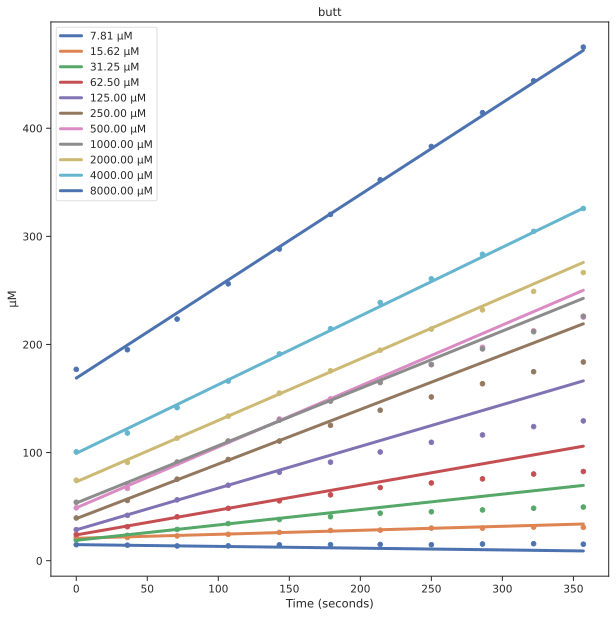

In [32]:
#Sanity check:
kinetics.get_initial_slopes(time_data[:,0], product_concentration[:,350,:].T, substrate_concs=conc_data, title='butt', plot=True)

In [33]:
###TODO:
# 1) ~~Is this working properly? Plots look weird.
#    Might be a weird dataset + line fitting errors, or a bug~~
#    Fixed! Was a bug in how time values were stored.
# 2) ~~I think addings nans kills the line fitting. Fix at some point. (in line fitting code, so we can keep nans?)~~
#    Fixed? Appears like it's working properly.
# 3) We're using the time values for the first chamber for all chambers. 
#    In practice, they're sometimes off by 1 second, which should not affect results much. Perhaps change in the future.
# 4) Kinetics fails without substrate_conc, even though it says it's optional. Also prints an ugly array which we should disable.

#make an array of initial slopes for each chamber: should be (#chambers , #concentrations) = (1792 x 11)
initial_slopes = None
initial_slopes_R2 = None
for i, chamber_idx in enumerate(chamber_idxs):

    current_chamber_slopes, current_chamber_R2 = kinetics.get_initial_slopes(time_data[:,0], product_concentration[:,i,:].T, substrate_concs=conc_data)

    #add a dimension at the end:
    current_chamber_slopes = np.expand_dims(current_chamber_slopes, axis=0)
    current_chamber_R2 = np.expand_dims(current_chamber_R2, axis=0)
    
    #add to our complete array:
    if initial_slopes is None:
        initial_slopes = current_chamber_slopes
        initial_slopes_R2 = current_chamber_R2
    else:
        initial_slopes = np.concatenate([initial_slopes, current_chamber_slopes], axis=0)
        initial_slopes_R2 = np.concatenate([initial_slopes_R2, current_chamber_R2], axis=0)




/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:52: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:57: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:89: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:92: RuntimeWarning:

invalid value encountered in scalar divide

/home/nfreitas/workspace/pinney/kinetic_analysis/kinetics/functions.py:93: RuntimeWarning:

invalid value encountered in scalar divide



 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to the data.
 This is likely due to scipy failing to fit a linear model to th

## Filter initial rates

#### Filters:
We will filter by masking our product_concentration array with NaN values

In [34]:
### Filter threshholds ###

#standard curve r^2 threshhold:
r2_threshold = 0.999

#enzyme expression threshhold:
expression_threshhold = 1.5
expression_threshhold_units = 'nM'

#initial rate fit R^2 threshhold:
intitial_rate_R2_threshhold = 0.8

In [35]:
### Make filters ###

# STANDARD CURVE FILTER #
# overwrite all chambers (rows) with r^2 values below the threshold with NaNs:
filter_r2 = np.ones_like(initial_slopes)
r2_values = np.array([db_conn._json_dict['runs']['standard_0']['analyses']['linear_regression']['chambers'][chamber_idx]['r2'] for chamber_idx in chamber_idxs])
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if r2_values[i] < r2_threshold:
        _count +=1
        filter_r2[i, :] = np.nan
print('Pearson r^2 filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# ENZYME EXPRESSION FILTER #
# overwrite all chambers (rows) with enzyme expression below the threshold with NaNs:
#Double check the expression units match the EGFP units:
assert expression_threshhold_units == EGFP_SLOPE_CONC_UNITS, 'Error, enzyme expression and EGFP standard curve units do not match!'
filter_enzyme_expression = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    if enzyme_concentration[i] < expression_threshhold:
        _count +=1
        filter_enzyme_expression[i,:] = np.nan
print('Enzyme expression filter: {}/{} chambers pass'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# INITIAL RATE FIT FILTER #
# overwrite just the assays per chamber (single values) with initial rate fit R^2 values below the threshold with NaNs:
filter_initial_rate_R2 = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    _chamber_count = 0
    for j in range(len(conc_data)):
        if initial_slopes_R2[i,j] < intitial_rate_R2_threshhold:
            _chamber_count +=1
            filter_initial_rate_R2[i,j] = np.nan
    if len(conc_data) - _chamber_count < 10:
        _count +=1
print('Initial Rate R^2 filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))

# POSITIVE INITIAL SLOPE FILTER #
# overwrite just the assays per chamber (single values) with initial slopes below zero with NaNs:
filter_positive_initial_slope = np.ones_like(initial_slopes)
_count = 0
for i, chamber_idx in enumerate(chamber_idxs):
    _chamber_count = 0
    for j in range(len(conc_data)):
        if initial_slopes[i,j] < 0:
            _chamber_count +=1
            filter_positive_initial_slope[i,j] = np.nan
    if len(conc_data) - _chamber_count < 10:
        _count +=1
print('Positive Initial Slope filter: {}/{} chambers pass with 10 or more slopes.'.format(len(chamber_idxs)-_count, len(chamber_idxs)))


### manually flagged wells ###
#TODO: implement

### TODO: make visualization!


Pearson r^2 filter: 1761/1792 chambers pass
Enzyme expression filter: 1197/1792 chambers pass
Initial Rate R^2 filter: 1792/1792 chambers pass with 10 or more slopes.
Positive Initial Slope filter: 1548/1792 chambers pass with 10 or more slopes.


In [36]:
### Filter data ###
#apply filters:
filters = [filter_r2, filter_enzyme_expression, filter_initial_rate_R2, filter_positive_initial_slope]

filtered_initial_slopes = deepcopy(initial_slopes)
for filter in filters: filtered_initial_slopes *= filter

In [37]:
# chamber_idxs, luminance_data, conc_data, time_data

#save filtered data to new analysis:
if 'analyses' not in db_conn._json_dict['runs']['kinetics_0'].keys():
    db_conn._json_dict['runs']['kinetics_0']['analyses'] = {}

#initialize the dictionary
db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered'] = {
        'filters': ['filter_r2', 'filter_enzyme_expression', 'filter_initial_rate_R2', 'filter_positive_initial_slope'],
        'filter_r2': r2_threshold,
        'filter_enzyme_expression': expression_threshhold,
        'filter_enzyme_expression_units': expression_threshhold_units,
        'filter_initial_rate_R2': intitial_rate_R2_threshhold,
        'filter_positive_initial_slope': True,
        'assays': {}} 

for i in range(len(conc_data)):
    db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i] = {
        'substrate_conc': conc_data[i],
        'chambers': {}
    }
    for j, chamber_idx in enumerate(chamber_idxs):
        db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered']['assays'][i]['chambers'][chamber_idx] = {
            'slope': filtered_initial_slopes[j,i],
            'r2': initial_slopes_R2[j,i]
        }

In [38]:
pprint(db_conn._json_dict['runs']['kinetics_0']['analyses']['initial_slopes_filtered'])

{'assays': {0: {'chambers': {'1,1': {'r2': 0.9844317436694613, 'slope': nan},
                             '1,10': {'r2': 0.9985761739179814,
                                      'slope': 0.02045369464550926},
                             '1,11': {'r2': 0.9851157127604807, 'slope': nan},
                             '1,12': {'r2': 0.9556249836778873,
                                      'slope': 0.012105321271101047},
                             '1,13': {'r2': 0.9603262078099354, 'slope': nan},
                             '1,14': {'r2': 0.9333373835354406, 'slope': nan},
                             '1,15': {'r2': 0.9996745629235869,
                                      'slope': 0.0369601831139014},
                             '1,16': {'r2': 0.9962974057280021,
                                      'slope': 0.02333176946359744},
                             '1,17': {'r2': 0.998984665171847,
                                      'slope': 0.02957718431589577},
                     

In [39]:
# # Here, we should take our filters from above, and ignore all wells that don't pass
# # pearson r2 value filter
# # slope < 0 filter
# # low enz expression
# # manually flagged wells
# # poor initial rate fits


# # NOTE: Need to decided on some standard filtering criteria for experiments
# # drop rows with initial rates =< 0
# cleaned_kinetics_df_filtered = cleaned_kinetics_df[cleaned_kinetics_df['initial_rate'] > 0]

# #drop rows with poor standard curves
# cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['std_r2'] > 0.98]

# #drop rows with poor expression
# cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['enzyme_conc_nM'] > 1.5]

# #drop flagged rows
# cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['mm_tofit_mask'] == True]

# #drop rows with poor initial rate fits
# cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['filter_initial_rate_r2'] > 0.8]

# cleaned_kinetics_df_filtered =cleaned_kinetics_df_filtered.dropna()

In [40]:
# #NF: Remove this, replace with visualization + flags.

# #manually inspect button quant image and exclude those with issues (positions are inverted from whats on the button summary image)
# to_drop = [(8,26),
#           (11,23),
#           (25,5),
#           (24,4),
#           (25,4),
#           (31,1),
#           (28,1),
#           (22,1),
#           (21,1),
#           (20,1),
#           (19,1),
#           (17,1),
#           (12,1),
#           (11,1),
#           (9,1),
#           (4,1),
#           (3,1),
#           (3,32),
#           (51,32),
#           (53,32),
#           (55,32),
#           (56,32),
#           ]

# cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered.loc[~cleaned_kinetics_df_filtered['position'].isin(to_drop)]

In [41]:
# # save fit filtered initial rates to a .csv
# cleaned_kinetics_df_filtered.to_csv('5_filtered_initial_rates.csv')
# cleaned_kinetics_df_filtered.head(2)


## Fit Michalis-Menten curves and visualize

**Important!** We must match our units for enzyme concentration with substrate concentration! 

In [42]:
substrate_conc_unit = db_conn._json_dict['runs']['kinetics_0']['conc_unit']
if  substrate_conc_unit != EGFP_SLOPE_CONC_UNITS: print('Enzyme concentration units do not match EGFP standard curve units! \n{} != {}'.format(substrate_conc_unit, EGFP_SLOPE_CONC_UNITS))

unit_converstion = 0.001 #convert FROM eGFP units TO substrate units (in this case, nM to uM)
enzyme_concentration_converted_units = enzyme_concentration * unit_converstion

#Double check!
print('Conversion:')
print('{} {} = {} {}'.format(enzyme_concentration[0], EGFP_SLOPE_CONC_UNITS, enzyme_concentration_converted_units[0], substrate_conc_unit))


Enzyme concentration units do not match EGFP standard curve units! 
uM != nM
Conversion:
0.07712728711840464 nM = 7.712728711840464e-05 uM


In [44]:
import kinetics

k_cat: 525.9366423102716 uM/s, k_M: 119.59521100159508 uM
Error: [ 0.07286679 29.4931035 ]
k_cat: 9.644592261307864 uM/s, k_M: 64.42145688545307 uM
Error: [6.91897551e-03 2.07767266e+01]
k_cat: 386.66924016081884 uM/s, k_M: 344.1725334991588 uM
Error: [ 0.18073287 75.06933499]
k_cat: 170.45976496325866 uM/s, k_M: 636.0226130378694 uM
Error: [5.94515366e-02 2.67176650e+02]
k_cat: 675.182077490878 uM/s, k_M: 183.8504974464557 uM
Error: [ 0.13318242 28.65854517]


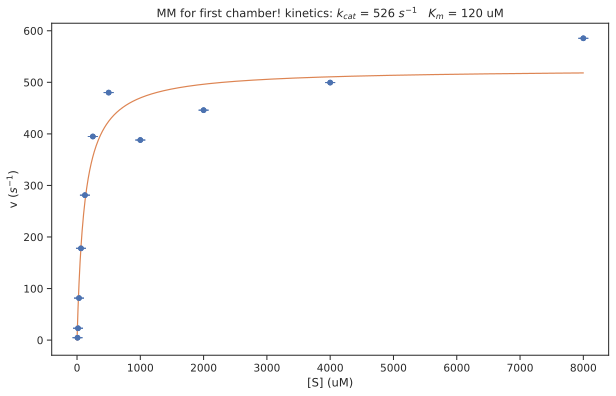

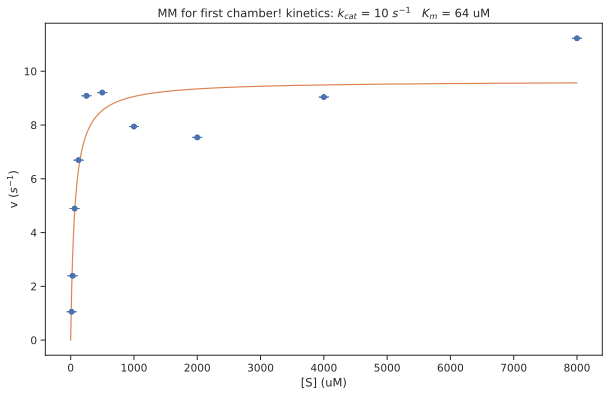

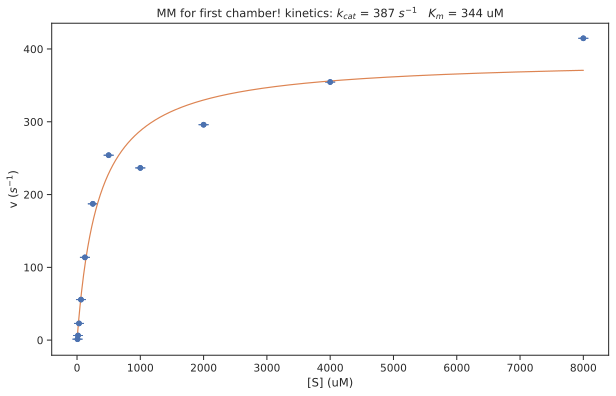

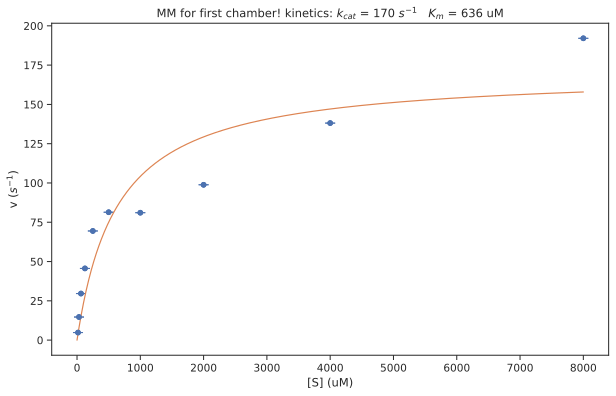

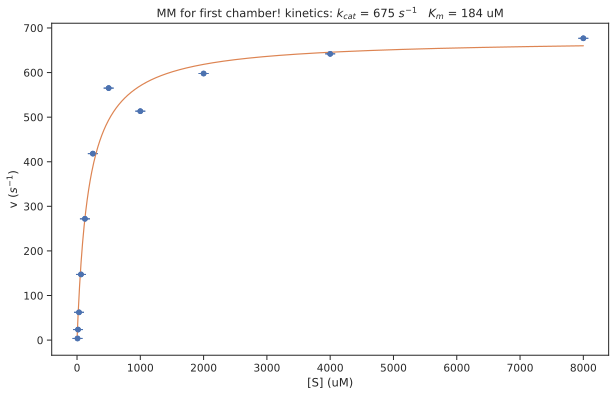

In [46]:
#filtered_initial_slopes[3, :]
for i in range(10):
    current_slopes = filtered_initial_slopes[i, :]

    if np.all(np.isnan(current_slopes)):
        continue

    #get indices of non-nan values:
    non_nan_idxs = np.where(~np.isnan(current_slopes))[0]
    
    current_slopes = current_slopes[non_nan_idxs]
    current_concs = conc_data[non_nan_idxs]
    
    kinetics.fit_and_plot_micheaelis_menten(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    k_cat, k_M, std_err = kinetics.fit_micheaelis_menten(current_slopes, current_slopes, current_concs, enzyme_concentration_converted_units[i], 'uM', 'MM for first chamber!')
    print('k_cat: {} uM/s, k_M: {} uM'.format(k_cat, k_M))
    print('Error: {}'.format(std_err))

## TODO Monday:
Below is the old 'fit MM by chamber' code. It looks like the old code was first trying to fit, and if it didn't work, then it was applying the filters? Not sure. Take a look/ask on Monday.
Also need to calculate Vmax - how?
Filters out outliers using some method, 
Does some statistics on MM parameters,
plot!
Then output as CSV. If we can do these on Monday we're golden


In [ ]:
# # takes a DataFrame of initial rates at different substrate concentrations as input and compresses these values 
# # into a single row pr chamber by returning a series where initial rate values and substrate concentrations are each a list
# def squeeze_initial_rates(df):
#     # Create a copy of the input DataFrame and sort it based on 'substrate_conc' column.
#     dfcopy = df.copy().sort_values('substrate_conc')
    
#     # Extract relevant data from the first row of the sorted DataFrame.
#     # These values are assumed to be the same for all rows in the group.
#     chamber_id = dfcopy.iloc[0]['id']
#     position = dfcopy.iloc[0]['position']
#     times = dfcopy.iloc[0]['time_s']
#     sum_chamber = dfcopy.iloc[0]['chamber_sum']
#     std_slope = dfcopy.iloc[0]['std_slope']
#     std_r2 = dfcopy.iloc[0]['std_r2']
#     substrate_name = dfcopy.iloc[0]['substrate_name']
#     assay_type = dfcopy.iloc[0]['assay_type']
#     chamber_product_concs = dfcopy.iloc[0]['chamber_product_concs']
#     summed_button = dfcopy.iloc[0]['summed_button']
#     summed_button_BGsub = dfcopy.iloc[0]['summed_button_BGsub']
#     enzyme_conc_nM = dfcopy.iloc[0]['enzyme_conc_nM']
    
#     # Insert zeros at the beginning of initial rate and substrate_conc columns to anchor our michaelis menten curves at 0,0.
#     substrate_conc = np.insert(dfcopy.substrate_conc.values.tolist(),0,0,axis = 0)
#     initial_rate = np.insert(dfcopy.initial_rate.values.tolist(),0,0,axis =0)
#     intercepts = np.insert(dfcopy.intercepts.values.tolist(), 0,0,axis = 0)
#     initial_rate_r2 = np.insert(dfcopy.initial_rate_r2.values.tolist(),0,0,axis = 0)

#     filter_initial_rate = np.insert(dfcopy.filter_initial_rate.values.tolist(),0,0,axis=0)
#     filter_intercepts = np.insert(dfcopy.filter_intercepts.values.tolist(), 0,0,axis = 0)
#     filter_initial_rate_r2 = np.insert(dfcopy.filter_initial_rate_r2.values.tolist(),0,0,axis = 0)
    
#     # Create a new pandas Series to store the extracted data.
#     squeezed_series = pd.Series(data = [chamber_id, times, sum_chamber, std_slope, std_r2, substrate_name, assay_type,chamber_product_concs,
#                                         summed_button,summed_button_BGsub, substrate_conc, initial_rate, intercepts, initial_rate_r2, 
#                                         filter_initial_rate, filter_intercepts, filter_initial_rate_r2, enzyme_conc_nM],
#                                index = ['id', 'time_s', 'sum_chamber', 'std_slope', 'std_r2', 'substrate_name', 'assay_type', 'chamber_product_concs', 
#                                         'summed_button', 'summed_button_BGsub', 'substrate_conc', 'initial_rate', 'intercept', 'initial_rate_r2', 
#                                         'filter_initial_rate', 'filter_intercepts', 'filter_initial_rate_r2','enzyme_conc_nM'])
#     return squeezed_series


# # Group the 'cleaned_kinetics_df_filtered' DataFrame by 'position' and apply 'squeeze_initial_rates' function to each group.
# squeezed_cleaned_fltered_kinetic_data = cleaned_kinetics_df_filtered.groupby('position').apply(squeeze_initial_rates).reset_index()
# squeezed_cleaned_fltered_kinetic_data.head(5)


In [ ]:
def fit_MM_by_chamber(row):
    #define the minimum number of initial rates needed to fit a michaelis menten curve. I usually expect 5 or 6.
    if len(row['initial_rate']) >5:
        try:
            params, _ = curve_fit(mm_model, np.insert(row['substrate_conc'], 0, 0), np.insert(row['initial_rate'], 0, 0) , p0=[np.median(row['substrate_conc']), np.max(row['initial_rate'])])
            vmax = params[0]
            km = params[1]
        except TypeError: 
            print("Could not fit")
            vmax = np.nan
            km = np.nan
    

        try:
            params, _ = curve_fit(mm_model, np.insert(row['substrate_conc'],0,0), np.insert(row['filter_initial_rate'],0,0) , p0=[np.median(row['substrate_conc']), np.max(row['filter_initial_rate'])])
            vmax_filter = params[0]
            km_filter = params[1]
        except TypeError: 
            print("Could not fit")
            vmax_filter = np.nan
            km_filter = np.nan
    
    
    else:
        vmax = np.nan
        km = np.nan
        vmax_filter = np.nan
        km_filter = np.nan
        
    return vmax, km, vmax_filter, km_filter

squeezed_cleaned_fltered_kinetic_data[['vmax', 'km', 'vmax_filter', 'km_filter']] = squeezed_cleaned_fltered_kinetic_data.apply(fit_MM_by_chamber, axis=1, result_type='expand')
squeezed_cleaned_fltered_kinetic_data.head(5)

In [ ]:
#Idea: Once we have initial fit for KM, have a view that flags each well by substrate "coverage":
#that is, whether our experiment had 1/10th and 10x substrate concentration than Vmax

In [ ]:
#extract kcat from vmax
squeezed_cleaned_fltered_kinetic_data['kcat'] = squeezed_cleaned_fltered_kinetic_data['vmax'].div((squeezed_cleaned_fltered_kinetic_data['enzyme_conc_nM']/1000))
squeezed_cleaned_fltered_kinetic_data['kcat_filtered'] = squeezed_cleaned_fltered_kinetic_data['vmax_filter'].div((squeezed_cleaned_fltered_kinetic_data['enzyme_conc_nM']/1000))
squeezed_cleaned_fltered_kinetic_data.head(10)

In [ ]:
#save michaelis menten fits to .csv
squeezed_cleaned_fltered_kinetic_data.to_csv('6_mm_fits_unfiltered.csv')


In [ ]:
# Filter out outliers for each variant
MM_outliers_removed = squeezed_cleaned_fltered_kinetic_data.copy()

def filter_outliers(group, z_threshold = 1.5):
    z_scores = (group - group.mean()) / group.std()
    return group[abs(z_scores) <= z_threshold]

# Define the columns for filtering
columns = ['enzyme_conc_nM', 'kcat', 'km'] #I also filtered on kcat and Km to exclude some bizarre fits that were unbounded

for column in columns:
    MM_outliers_removed[column + '_z_filtered'] = MM_outliers_removed.groupby('id')[column].transform(filter_outliers)
    
MM_outliers_removed = MM_outliers_removed.dropna()
MM_outliers_removed.head(5)


In [ ]:
#save filtered michaelis menten fits to .csv
MM_outliers_removed.to_csv('7_mm_fits_filtered.csv')
MM_outliers_removed.shape[0]


In [ ]:
#Note: plot chip by R2 of exponential fit, then show individual graphs
#Or, do same just by linear fit.

#plot michaelis menten curves by variant/id

# Group the data by 'id' column
groups = MM_outliers_removed.groupby('id')

# Calculate the number of rows and columns
num_groups = len(groups)
num_columns = 4
num_rows, remaining = divmod(num_groups, num_columns)
if remaining > 0:
    num_rows += 1

#print(groups)

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 4*num_rows), sharex=True)

# Iterate over the groups and plot the data on separate subplots
for i, (ortholog_name, ortholog_data) in enumerate(groups):
    # Get the corresponding subplot for the current group
    ax = axs.flat[i]
    vmax_norm_ave = []
    # Plot the data for the current group
    for _, row in ortholog_data.iterrows():
        ax.scatter(row['substrate_conc'], [(v/(row['enzyme_conc_nM']/1000)) for v in row['initial_rate']], label=row['position'])
        x = np.linspace(0, 16000, 1000)
        ax.plot(x, mm_model(x, row['kcat'], row['km']))
    
    # Set labels and title for the subplot
    ax.set_xlabel('Substrate Concentration (µM)')
    ax.set_ylabel('Initial Rate/[E] ($s^{-1}$)')
    ax.set_title(f'{ortholog_name}')
    
    # Show the legend for the subplot
    ax.legend(fontsize='small')
    ax.legend()

# Adjust spacing between subplots
fig.tight_layout()
plt.rcParams['pdf.fonttype'] = 42

# plt.savefig('{}.pdf'.format('MM_curves_unfiltered_initial_rate'), format='pdf')
plt.clf()

In [ ]:
# takes a DataFrame of michaelis menten parameters for different chambers as input and compresses these values 
# into a single row per variant by returning a series where michaelis menten parameters are each a list

def squeeze_replicates(df):
    # Create a copy of the input DataFrame and sort it based on 'id' column.
    dfcopy = df.copy().sort_values('id')
    
    # Extract relevant information that is assumed to be the same for all rows within the group.
    substrate_name = dfcopy.iloc[0]['substrate_name']
    assay_type = dfcopy.iloc[0]['assay_type']

    # Calculate the number of replicates in the group.
    replicates = dfcopy.shape[0]

    # Extract specific column data as lists for each replicate within the group.
    summed_button = dfcopy.summed_button.values.tolist()
    summed_button_BGsub = dfcopy.summed_button_BGsub.values.tolist()
    positions = dfcopy.position.values.tolist()
    substrate_conc = dfcopy.substrate_conc.values.tolist()
    initial_rate = dfcopy.initial_rate.values.tolist()
    initial_rate_r2 = dfcopy.initial_rate_r2.values.tolist()
    vmax = dfcopy.vmax.values.tolist()
    km = dfcopy.km.values.tolist()
    vmax_filter = dfcopy.vmax_filter.values.tolist()
    km_filter = dfcopy.km_filter.values.tolist()
    kcat = dfcopy.kcat.values.tolist()
    kcat_filtered = dfcopy.kcat_filtered.values.tolist()
    enzyme_conc_nM = dfcopy.enzyme_conc_nM.values.tolist()

    # Create a new pandas Series to store the extracted data for all replicates within the group.
    squeezed_series = pd.Series(data = [substrate_name, assay_type, summed_button, summed_button_BGsub, positions, substrate_conc, initial_rate, initial_rate_r2, vmax, km, vmax_filter, km_filter, kcat, kcat_filtered,enzyme_conc_nM, replicates],
                               index = ['substrate_name', 'assay_type', 'summed_button', 'summed_button_BGsub', 'positions', 'substrate_conc', 'initial_rate', 'initial_rate_r2', 'vmax', 'km', 'vmax_filter', 'km_filter', 'kcat', 'kcat_filtered','enzyme_conc_nM', 'replicates'])
    return squeezed_series

# Group the DataFrame by 'id' and apply 'squeeze_replicates' function to each group of replicates.
squeezed_MM_data = MM_outliers_removed.groupby('id').apply(squeeze_replicates).reset_index()


In [ ]:
# Function to calculate various statistics related to Michaelis-Menten (MM) kinetic parameters.
# The function takes a row (replicate) from the DataFrame as input and returns calculated statistics.

def MM_stats(row):
    
    # Function to calculate the interquartile range (IQR) of a given data array.
    def IQR(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
    
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        return iqr


        
    # Extract relevant data for calculations from the row (set of replicates).
    summed_button = row['summed_button']
    vmax = row['vmax']
    vmax_filter = row['vmax_filter']
    
    kcats = row['kcat']
    kcats_filtered = row['kcat_filtered']
    vmaxs = row['vmax']
    vmaxs_filter = row['vmax_filter']

    # Calculate various statistics for kcat, Km, and vmax parameters and enzyme concentration.
    kcat_mean = np.mean(kcats)
    kcat_stdev = np.std(kcats)
    kcat_median = np.median(kcats)
    kcat_iqr = IQR(kcats)

    kcat_mean_filtered = np.mean(kcats_filtered)
    kcat_stdev_filtered = np.std(kcats_filtered)
    kcat_median_filtered = np.median(kcats_filtered)
    kcat_iqr_filtered = IQR(kcats_filtered)

    Km_mean = np.mean(row['km'])
    Km_stdev = np.std(row['km'])
    Km_median = np.median(row['km'])
    Km_iqr = IQR(row['km'])

    Km_mean_filtered = np.mean(row['km_filter'])
    Km_stdev_filtered = np.std(row['km_filter'])
    Km_median_filtered = np.median(row['km_filter'])
    Km_iqr_filtered = IQR(row['km_filter'])

    vmax_mean = np.mean(vmaxs)
    vmax_stdev = np.std(vmaxs)
    vmax_median = np.median(vmaxs)
    vmax_iqr = IQR(vmaxs)

    vmax_mean_filtered = np.mean(vmaxs_filter)
    vmax_stdev_filtered = np.std(vmaxs_filter)
    vmax_median_filtered = np.median(vmaxs_filter)
    vmax_iqr_filtered = IQR(vmaxs_filter)

    enzyme_conc_nM_mean = np.mean(row['enzyme_conc_nM'])
    enzyme_conc_nM_stdev = np.std(row['enzyme_conc_nM'])
    
    return kcat_mean, kcat_stdev, kcat_median, kcat_iqr, Km_mean, Km_stdev, Km_median, Km_iqr, kcat_mean_filtered, kcat_stdev_filtered, kcat_median_filtered, kcat_iqr_filtered, Km_mean_filtered, Km_stdev_filtered, Km_median_filtered, Km_iqr_filtered, enzyme_conc_nM_mean, enzyme_conc_nM_stdev,vmax_mean, vmax_stdev, vmax_median, vmax_iqr, vmax_mean_filtered, vmax_stdev_filtered, vmax_median_filtered, vmax_iqr_filtered
    

squeezed_MM_data[['kcat_mean', 'kcat_stdev', 'kcat_median', 'kcat_iqr', 'Km_mean', 'Km_stdev', 'Km_median', 'Km_iqr', 'kcat_mean_filtered', 
                  'kcat_stdev_filtered', 'kcat_median_filtered', 'kcat_iqr_filtered', 'Km_mean_filtered', 'Km_stdev_filtered', 'Km_median_filtered', 
                  'Km_iqr_filtered', 'enzyme_conc_nM_mean','enzyme_conc_nM_stdev', 'vmax_mean', 'vmax_stdev', 'vmax_median', 'vmax_iqr', 'vmax_mean_filtered', 
                 'vmax_stdev_filtered', 'vmax_median_filtered', 'vmax_iqr_filtered']] = squeezed_MM_data.apply(MM_stats, axis=1, result_type='expand')
squeezed_MM_data.head(10)         

In [ ]:
#clean up dataframe
cleaned_MM = squeezed_MM_data.drop(
    columns=[
        "summed_button",
        "summed_button_BGsub",
        "positions",
        "initial_rate",
        "initial_rate_r2",
        "vmax", 
        "km", 
        "substrate_conc",
        "vmax_filter",
        "km_filter",
        "kcat",
        "kcat_filtered",
        "enzyme_conc_nM"
    ]
)

cleaned_MM.sort_values(by = 'kcat_median')

In [ ]:
# add organism name to each row
def org_name(row):
    #with open("/Users/margauxpinney/code/lab-notebook-pinney/20230629/adkLibrary_original.fasta", 'r') as lib_file:
    with open(root+'/adkLibrary_original.fasta', 'r') as lib_file:
        orth_dict = {}
        for line in lib_file.readlines():
            if line[0] == ">":
            
                org_name = line.split("|")[2]
        
                abbrev = f"{org_name[0].upper()}_{org_name.split('_')[-1][:4]}_ADK"
                orth_dict[abbrev] = org_name
    orth_dict['bsADK'] = 'bacillus_subtilis'
    orth_dict['gsADK'] = 'geobacillus_stearothermophilus'
    orth_dict['bmADK'] = 'bacillus_marinus'
    orth_dict['Sym_ther_ADK'] = 'symbiobacterium_thermophilum'
    orth_dict['mpADK'] = 'mesotoga_prima'
    orth_dict['miADK'] = 'mesotoga_infera'
    orth_dict['ecADK_HTA'] = 'escherichia_coli_heat_adapted'
    
    
    
    try:
        name = orth_dict[row['id']]
    except:
        name = '-'
        
    return name
    
    
cleaned_MM['name'] = cleaned_MM.apply(org_name, axis=1)

cleaned_MM.sort_values(by = 'kcat_median')

In [ ]:
#add the optimal growth temperature to each row
temperature_table = pd.read_table("temperature_data_full.tsv", header=0)
temperature_table = temperature_table[["organism", "temperature"]]

MM_final = pd.merge(cleaned_MM, temperature_table, left_on = 'name', right_on = 'organism', how = 'left').drop(columns = 'name').sort_values(by='kcat_mean')
MM_final

In [ ]:
#save the final table of michaelis menten parameters to a .csv
MM_final.to_csv('8_Final_MM_Data.csv')

In [ ]:
MM_final.shape[0]